In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [3]:
path = "D:\BaiduNetdiskDownload\data\donghai\\2011-2014.nc"
dataset = xr.open_dataset(path)

In [4]:
# 目标D经纬度坐标
target_longitude = 124.00
target_latitude = 31.00

In [5]:
# 固定经度和纬度并获取其余信息
subset_data = dataset.sel(longitude=target_longitude, latitude=target_latitude, method='nearest')

In [6]:
time = subset_data.variables['time'][:].data
u10 = subset_data.variables['u10'][:].data
v10 = subset_data.variables['v10'][:].data
swh = subset_data.variables['swh'][:].data
print(swh[0])

4.016243


In [7]:
# 创建DataFrame来组织数据
data = pd.DataFrame({'time': time, 'u10': u10, 'v10': v10, 'swh': swh})

In [8]:
X = data[['u10', 'v10', 'swh']].values
y = data['swh'].values
y = np.roll(y,shift=-3)


In [9]:
# 划分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化特征
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# 创建LSTM模型
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# 为LSTM模型调整数据形状
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [12]:
# 训练模型
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
877/877 [==============================] - 3s 2ms/step - loss: 0.9886
Epoch 2/10
877/877 [==============================] - 2s 2ms/step - loss: 0.0870
Epoch 3/10
877/877 [==============================] - 1s 2ms/step - loss: 0.0386
Epoch 4/10
877/877 [==============================] - 1s 2ms/step - loss: 0.0382
Epoch 5/10
877/877 [==============================] - 2s 2ms/step - loss: 0.0371
Epoch 6/10
877/877 [==============================] - 2s 2ms/step - loss: 0.0365
Epoch 7/10
877/877 [==============================] - 1s 2ms/step - loss: 0.0363
Epoch 8/10
877/877 [==============================] - 2s 2ms/step - loss: 0.0355
Epoch 9/10
877/877 [==============================] - 2s 2ms/step - loss: 0.0354
Epoch 10/10
877/877 [==============================] - 2s 2ms/step - loss: 0.0349


In [13]:
# 预测波高
y_pred = model.predict(X_test)

220/220 [==============================] - 0s 1ms/step


In [14]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

RMSE: 0.19711415924967132


In [15]:
from scipy.stats import pearsonr

r, _ = pearsonr(y_test, y_pred)
print("Correlation coefficient (R):", r)

Correlation coefficient (R): [0.9852100362469987]


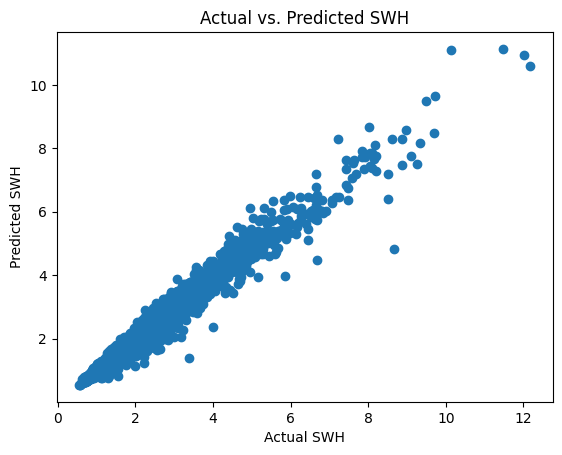

In [16]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel("Actual SWH")
plt.ylabel("Predicted SWH")
plt.title("Actual vs. Predicted SWH")
plt.show()

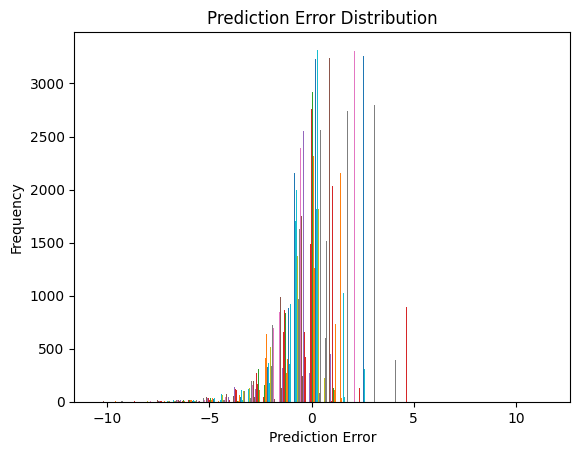

In [17]:
errors = y_test - y_pred
plt.hist(errors, bins=30)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Prediction Error Distribution")
plt.show()